# RMS to interval velocity problem 

Forward mapping 

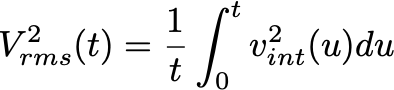

- $v_int$: interval velocity
- $V_{rms}$: rms velocity 

inverse mapping 

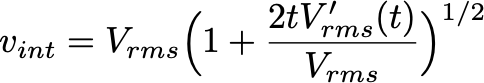

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## define interval velocity 

$$v_{int} = v_0 + a \sin(2\pi f t)$$

In [3]:
def interval_velocity_analytic(t, v0, a, f): 
    """
    define our interval velocity as a harmonic function with amplitude (a), frequency (f), and base-value v0
    """
    return v0 + a *np.sin(2*np.pi*f*t)

In [4]:
a = 50
v0 = 2000 
f = 2

In [14]:
n_times = 200 
max_time = 2
time = np.linspace(0, 2, n_times)

In [17]:
# vint = interval_velocity_analytic(time, v0, a, f)
vint = interval_velocity_analytic(t=time, v0=v0, a=a, f=f)

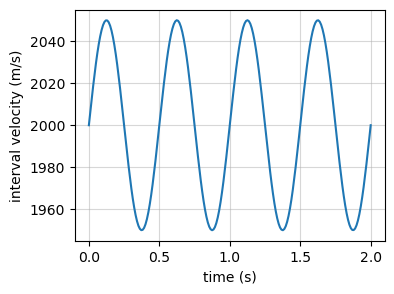

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3)) 

ax.plot(time, vint)
ax.set_xlabel("time (s)")
ax.set_ylabel("interval velocity (m/s)")
ax.grid(alpha=0.5)

# forward problem 

$$V_{rms}^2 (t) = \frac{1}{t}\int_0^{t_{max}} v_{int}^2(u) du$$

with 
- $v_{int} = v_0 + a \sin(2\pi f t)$
- $v_{int} = v_0 + a \sin(\omega t)$

The answer 

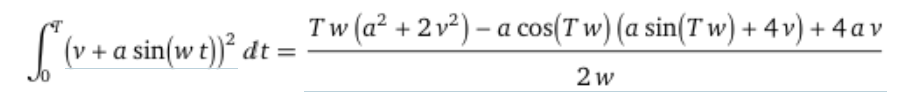